### Analysis of Polio Incidences Tutorial

This notebook, like the others, uses cpus.  GPUs can be used in pyspark, dask and ray.  See a sepparate tutorial for that approach.  This tutorial is for beginners and uses a small dataset.  You will not see a speed up in wall clock time until at minimum gigabytes of data are being used.

In this notebook we use the libraries sklearn and xgboost to perform machine learning.  Our dataset is contains information on the incidence ratios of polio by year starting in 1928.  While a forcasting algorithm may have yielded interesting results, here we use a simple classifier to create a predictor of incidence ratios in our test dataset.  

To learn about sklearn and dask, we also use the cannonical scikit learn tutorial on comparison of different regressors (classifiers) on predefined datasets.  After this demonstration we dive into using xgboost and dask.  Finally we use xgboost tree method, 'hist' to create a classifer for our polio data.  Let's get started.

### Setting up the Dask Cluster

To set up Dask in local mode (on your laptop, without distributed characteristics), use the code containing the command LocalCluster. To start Dask on a cluster, use either the client code that uses the cluster scheduler address, (which you will need to look up on your Dask Web UI) or the code which contains the automatic look-up for the service host and port.  Let's use the third method.  The other two are commented out.

In [ ]:
## set up the cluster in local mode if desire parallelism only

from dask.distributed import LocalCluster, Client
cluster = LocalCluster(n_workers = 2)
client = Client(cluster)
client

Setting up the cluster to run in distributed mode requires that the scheduler is called.  One do so with the code below.

In [1]:
from dask.distributed import Client
import os

service_host = os.environ["DASK_SCHEDULER_SERVICE_HOST"]
service_port = os.environ["DASK_SCHEDULER_SERVICE_PORT"]
client = Client(f"{service_host}:{service_port}")

# look at the client and scheduler

client

# you should now be connected to the cluster
# Dashboard link from the client object is clickable but will not route in Domino
# Use the embedded Dask Web UI tab instead

/opt/conda/lib/python3.8/site-packages/distributed/client.py:1096: VersionMismatchWarning: Mismatched versions found

+-------------+-----------+-----------+-----------+
| Package     | client    | scheduler | workers   |
+-------------+-----------+-----------+-----------+
| dask        | 2022.01.0 | 2021.10.0 | 2021.10.0 |
| distributed | 2022.01.0 | 2021.10.0 | 2021.10.0 |
| lz4         | 3.1.10    | 3.1.3     | 3.1.3     |
| msgpack     | 1.0.3     | 1.0.2     | 1.0.2     |
| toolz       | 0.11.2    | 0.11.1    | 0.11.1    |
+-------------+-----------+-----------+-----------+
Notes: 
-  msgpack: Variation is ok, as long as everything is above 0.6
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


<Client: 'tcp://10.0.46.209:8786' processes=2 threads=2, memory=8.00 GiB>

### What can Dask do?

Dask is a distributed computing api that excels at machine learning at scale.  We can see that user CPU times are greatly reduced even on a small task like calculating pi.  However wall-clock time (the amount of time that passes by as we experienced it) does not get reduced until the data is large.  When data is so large that it will not fit onto a single node, Dask can still do its job.  This follows the old adage, don't distribute until you need to do so because you won't notice much of a speed-up in time for small tasks.

Let's look at calculating pi to see what what is going on here. 

First we'll import the libraries we need.

In [2]:
import dask
import dask.array as da
import numpy as np
import dask.dataframe as dd
import pandas as pd
import time
import seaborn as sn

### Calculating Pi without and with using Dask: Watch for how the Code Is Written

Let's calculate pi without using Dask and see how long it takes for the cpu (pay attention to total cpu time), the user and the wall-clock time.  This is showing why dask code needs to be written correctly.  

In [ ]:
import time
## compute pi without Dask - WIP - doesn't seem to be available

def pi(N):
    time.sleep(10)

    # Initialize denominator
    k = 1

    # Initialize sum
    s = 0

    for i in range(N):

        # even index elements are positive
            if i % 2 == 0:
                s += 4/k
            else:
                s -= 4/k

        # denominator is odd
            k += 2
    return s


In [ ]:
%%time
pi(10**7)

### Calculating Pi Using Dask the Wrong Way

To calculate pi using dask, we can use the decorator function @dask.delayed or just delayed and the compute function to retrieve the output of our pi calculation. We can also use the client function to compute pi.  The delayed function will run tasks in parallel and is especially helpful for custom algorithms.  The client function will run dasks in parallel and distribute them in the cluster.  Although in the example below all of our code runs, and we call the right functions, this is not the most effective way to write code for dask.

Take a close look at the total cpu time and total wall clock time.  The CPU time is at many times less when using Dask, but the wall clock time is the same.  What do you think is wrong with the code in this procedure?  Why doesn't the wall-clock time improve? Hint: Is Dask creating a 'future calculation' that is performed once the function is actually called?  In otherwords at runtime calculation?

In [3]:
import time
## compute pi without Dask - WIP - doesn't seem to be available


def pi(N):
    time.sleep(10)

    # Initialize denominator
    k = 1

    # Initialize sum
    s = 0

    for i in range(N):

        # even index elements are positive
            if i % 2 == 0:
                s += 4/k
            else:
                s -= 4/k

        # denominator is odd
            k += 2
    return s


In [4]:
%%time

pi_client = client.submit(pi, 10**7)
pi_client = pi_client.result()
print(pi_client)

3.1415925535897915
CPU times: user 52 ms, sys: 29.3 ms, total: 81.3 ms
Wall time: 10.9 s


In [ ]:
%%time

from dask import delayed

pi = delayed(pi)(10**7)
pi.compute()

So we can see above that the fast calculations happen when calling pi with or without Dask (using the delayed or submit methods) with a wall-clock time is about 11 seconds.  What's the problem here?  Why isn't Dask making the code run faster?

### Speeding up the calculation of Pi, we need to write the code so it can be parallelized or distributed.  See example below.

Here we create a function that can be run with only using only 1 term at a time, a iterating over a list and a single calculation (sum function).  This function of pi will run in parallel on Dask.  You will notice an immediate time improvement.  You'll notice that a single task is given in the routine which takes in a single term.  This is not the only way to parallelize a function, but in this case it is effective because it breaks larger tasks into smaller ones that can be run in parallel. In the code below you see how calculate pi in three ways, two of which use Dask.  The methods we show are correct and work:

- without Dask

- with paralellism and using futures (```delay``` function)

- with paralellism and distributed on the cluster (```client``` function)

Which way is fastest?  Why do you think so?  Hint: using the client function will distribute tasks over a cluster.

In [20]:
import time

def pi_single_term(i):
    time.sleep(0.01)
    # denominator is odd
    k = 2*i + 1
    # even index elements are positive
    if i % 2 == 0:
        x = 4/k
    # odd index elements are negative    
    else:
        x = - 4/k
    return x

In [ ]:
%%time
## compute pi without Dask
s = []
for i in range(10**3):
    s.append(pi_single_term(i))
sum(s)

In [21]:
%%time
## compute pi with Dask using Delayed

s = []
for i in range(10**3):
    s.append(dask.delayed(pi_single_term)(i))
dask.delayed(sum)(s).compute()

CPU times: user 125 ms, sys: 65.1 ms, total: 190 ms
Wall time: 2.61 s


3.140592653839794

In [ ]:
#!echo $PATH
#dask.delayed(sum)(s).visualize()

In [ ]:
%%time
## compute pi with Dask using Client

s=[]
for i in range(10**3):
    s.append(client.submit(pi_single_term, i))
client.submit(sum, s).result()

### There is more than one way to call a Dask function.

Below are two examples of how to call a dask function.  The first uses @dask.delayed (lazy loading) and the second uses the Dask client (distributing over a cluster).  Either will be useful for work in different contexts.  When doing very large calculations on very large data, using the cluster will give the best performance improvement.  As a reminder:

- dask.delayed works with the decorator delayed or using delayed in front of the function
- dask uses the client function to submit jobs to the cluster
- both methods use parallelism
- the client function uses distributed computing over a cluster
- both functions will speed up the code if the code is written correctly (use small tasks and parallelize and distribute the workload among workers)

With ```dask.delayed```, we get a future that is not called until compute is used.  So the future can be sent to a local or distributed cluster, but the calculation does not occur until the cluster is told to do the computation using ```.compute```.  This is why dask.delayed will often be very slightly longer than using the ```client.result()``` method.

In [ ]:
%%time

import dask

@dask.delayed
def inc(x):
   return x + 1

@dask.delayed
def add(x, y):
   return x + y

a = inc(1)       # no work has happened yet
b = inc(2)       # no work has happened yet
c = add(a, b)    # no work has happened yet
c = c.compute()  # work starts and finishes
print(c)

When we use ```client.result().submit``` we are both creating a future for the cluster to compute and telling the cluster to make the computation at the same time.  Thus it will be slightly faster most times compared to ```dask.delayed().compute``` which uses futures.  The difference is nominal in most cases.

In [ ]:
%%time 
from dask.distributed import Client

#client = Client() - if wish to run in local mode for parallelism only

def inc(x):
   return x + 1

def add(x, y):
   return x + y

a = client.submit(inc, 1)     # work starts immediately
b = client.submit(inc, 2)     # work starts immediately
c = client.submit(add, a, b)  # work starts immediately
c = c.result()
print(c)

### Dask can be faster using Parallelism with Distributed Compute and Multiple Terms

The delayed function or delayed function decorator and client functions can speed up some computations that rely upon one another. See the example below for an instance in which wall-clock time is speed up through parallelizing the code using either the delayed function or the client function.  Notice that each function has one output, and each function has one task.  If we made one function that did all the tasks of inc and add together, it would not paralllize the code as written.  Dask might seem tricky, but writing code with smaller tasks in a larger computation, will make it possible to parallelize the tasks over many workers.

In [ ]:
# notice we have one function for adding and one for subtracting; not a function for both

from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [ ]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)
z

In [ ]:
%%time
from dask import delayed
# This runs faster because it uses parallelism

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)
z.compute()

In [ ]:
%%time

x = client.submit(inc, 1)
y = client.submit(inc, 2)
z = client.submit(add, x, y)
z.result()

### Using Pandas-like Functions with Dask Dataframes

Below are two examples of reading in and a quick analysis of the polio dataset.  Notice that there is practically no syntax change between using Pandas and dask.  The main difference is whether a pandas data frame or a dask dataframe is used.  A Dask dataframe is set up so that data can be distributed among workers.  Pandas dataframes do not do such functions in their native state.

In [5]:
import pandas as pd

df = pd.read_csv("/mnt/data/ondemand-cluster-demo/polioData.csv")

def get_counts(df):
    by_state = df.groupby("state")
    incidence = by_state["incidence_ratio"]
    return incidence.value_counts()

result = get_counts(df)
result.sort_values(ascending=False, inplace=True)

print(result)
df.head()

state  incidence_ratio
DE     0.00               1072
WY     0.00               1043
UT     0.00                949
MT     0.00                940
ID     0.00                940
                          ... 
KY     1.14                  1
       1.13                  1
       1.06                  1
       1.05                  1
WY     8.93                  1
Name: incidence_ratio, Length: 6939, dtype: int64


,year,week,region,loc,state,number,population,incidence_ratio
0,1928,1,South,2,AL,0.0,2640000,0.00
1,1928,2,South,2,AL,0.0,2640000,0.00
2,1928,3,South,2,AL,1.0,2640000,0.04
3,1928,4,South,2,AL,0.0,2640000,0.00
4,1928,5,South,2,AL,0.0,2640000,0.00


In [7]:
import dask.dataframe as dd

dd = dd.read_csv("/mnt/data/ondemand-cluster-demo/polioData.csv",assume_missing=True)

def get_counts(df):
    by_state = df.groupby("state")
    incidence = by_state["incidence_ratio"]
    return incidence.value_counts()

result = get_counts(dd)
result = result.compute(num_workers=2)
result.sort_values(ascending=False, inplace=True)

print(result)

state  incidence_ratio
DE     0.00               1072
WY     0.00               1043
UT     0.00                949
ID     0.00                940
MT     0.00                940
                          ... 
KY     1.19                  1
       1.18                  1
       1.14                  1
       1.13                  1
WY     8.93                  1
Name: incidence_ratio, Length: 6939, dtype: int64


### Working with Dataframes and Doing Simple Data Analytics: Dask has Pandas-like Syntax and Functions

Let's take a look at an analysis using pandas and dask.  We will read in the dataframes in both.  You will see a familiar pattern if you've taken the spark tutorial (pyspark or sparklyR).  We're in fact doing the same processes we did in spark in dask.

In [8]:
df = pd.read_csv('/mnt/data/ondemand-cluster-demo/polioData.csv', header=0)
df.head()

,year,week,region,loc,state,number,population,incidence_ratio
0,1928,1,South,2,AL,0.0,2640000,0.00
1,1928,2,South,2,AL,0.0,2640000,0.00
2,1928,3,South,2,AL,1.0,2640000,0.04
3,1928,4,South,2,AL,0.0,2640000,0.00
4,1928,5,South,2,AL,0.0,2640000,0.00


In [9]:
import dask
import dask.dataframe as dd

df_dask = dd.read_csv('/mnt/data/ondemand-cluster-demo/polioData.csv', header=0, assume_missing=True)
df_dask.head()

,year,week,region,loc,state,number,population,incidence_ratio
0,1928.0,1.0,South,2.0,AL,0.0,2640000.0,0.00
1,1928.0,2.0,South,2.0,AL,0.0,2640000.0,0.00
2,1928.0,3.0,South,2.0,AL,1.0,2640000.0,0.04
3,1928.0,4.0,South,2.0,AL,0.0,2640000.0,0.00
4,1928.0,5.0,South,2.0,AL,0.0,2640000.0,0.00


In [10]:
## look at columns, rows

df_dask.columns

Index(['year', 'week', 'region', 'loc', 'state', 'number', 'population',
       'incidence_ratio'],
      dtype='object')

In [11]:
## using pandas to describe the dataframe

df.describe()

,year,week,loc,number,population,incidence_ratio
count,81531.000000,81531.000000,81531.000000,81484.000000,8.153100e+04,81531.000000
mean,1944.968969,27.756350,2.543940,6.146102,3.179199e+06,0.217488
std,10.640083,14.760006,1.017445,20.992594,3.219969e+06,0.609224
min,1928.000000,1.000000,1.000000,0.000000,1.000000e+05,0.000000
25%,1936.000000,15.000000,2.000000,0.000000,8.470000e+05,0.000000
50%,1944.000000,29.000000,2.000000,1.000000,2.262000e+06,0.030000
75%,1954.000000,41.000000,3.000000,3.000000,3.784000e+06,0.160000
max,1968.000000,52.000000,4.000000,676.000000,1.939400e+07,33.080000


So far all our approaches have been the same for dask and for pandas. Here is one place where they differ.  The describe function on a dask dataframe will not provide the expected statistics.  Instead we do the following (see the cells below the df_dask.describe.  In general, remember Dask creates Futures which do not get executed until the ```.compute``` is called.

- wrong way is shown first, i.e. df_dask.describe()
- correct way is shown second

In [ ]:
## describe dask dataframe, looks different as it does not do any calculations on the df,
## dask only does the describe function only indicates the number of partitions unless compute is called

dd.DataFrame.describe(df_dask)

,year,week,loc,number,population,incidence_ratio
npartitions=1,,,,,,
,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...


In [13]:
describe = dd.DataFrame.describe(df_dask).compute()
describe

KeyboardInterrupt: 

In [14]:
df.head()

,year,week,region,loc,state,number,population,incidence_ratio
0,1928,1,South,2,AL,0.0,2640000,0.00
1,1928,2,South,2,AL,0.0,2640000,0.00
2,1928,3,South,2,AL,1.0,2640000,0.04
3,1928,4,South,2,AL,0.0,2640000,0.00
4,1928,5,South,2,AL,0.0,2640000,0.00


In [15]:
df_dask.head()

,year,week,region,loc,state,number,population,incidence_ratio
0,1928.0,1.0,South,2.0,AL,0.0,2640000.0,0.00
1,1928.0,2.0,South,2.0,AL,0.0,2640000.0,0.00
2,1928.0,3.0,South,2.0,AL,1.0,2640000.0,0.04
3,1928.0,4.0,South,2.0,AL,0.0,2640000.0,0.00
4,1928.0,5.0,South,2.0,AL,0.0,2640000.0,0.00


### The following is an example of K-means clustering using Sklearn Natively versus Dask's Machine Learning Library

This example shows at least a five-fold faster training using Dask's Machine Learning library with syntax very similar to sci-kit learn.  Running using the Dask library will distribute training across nodes.  

Using Sci-kit Learn natively on Dask we see a training time as noted below.

In [12]:
# import libraries

from sklearn import cluster
import time
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
X, y = datasets.make_blobs(n_samples=10**8, random_state=0,
                                   centers=3)

In [14]:
%%time

km = cluster.KMeans(n_clusters=3)
km.fit(X)

CPU times: user 4min 45s, sys: 1min 8s, total: 5min 53s
Wall time: 2min 55s


KMeans(n_clusters=3)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X[::10000, 0], X[::10000, 1], marker='.', c=km.labels_[::10000],
           cmap='viridis', alpha=0.25);

Using Dask's ML library we make very minor code changes, but have a large speed-up of training time.

In [15]:
## import dask ml libraries

import dask_ml.datasets
import dask_ml.cluster
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
X, y = dask_ml.datasets.make_blobs(n_samples=10**8,
                                   chunks=1000000,
                                   random_state=0,
                                   centers=3)
X = X.persist()
X

dask.array<concatenate, shape=(100000000, 2), dtype=float64, chunksize=(1000000, 2), chunktype=numpy.ndarray>

In [17]:
%%time

km = dask_ml.cluster.KMeans(init='k-means||', n_clusters=3, init_max_iter=2, oversampling_factor=10)
km.fit(X)

CPU times: user 2min 41s, sys: 2min 29s, total: 5min 10s
Wall time: 1min 18s


KMeans(init_max_iter=2, n_clusters=3, oversampling_factor=10)

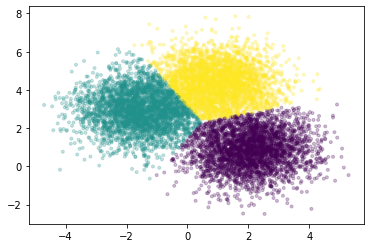

In [18]:
fig, ax = plt.subplots()
ax.scatter(X[::10000, 0], X[::10000, 1], marker='.', c=km.labels_[::10000],
           cmap='viridis', alpha=0.25);

### Using the XGBoost Library on Dask

Xgboost library now has Dask incorporated into it.  Lets first run a test using synthetic data.  Please notice we are running this test in local mode.  That means the data is parallelized but not distributed.  To run in distributed mode, use the instructions at the start of the tutorial.  When using the command LocalCluster(), a cluster will be set up locally on a single node.  If no client is created, it will run on the default cluster, i.e. the one that was started at the top of this notebook.  It is an ideosyncrocay of the xgboost's integration of dask.

In [ ]:
## perform a regression based on state and incidence ratio
import xgboost as xgb
import dask.array as da
import dask.distributed


cluster = dask.distributed.LocalCluster()
client = dask.distributed.Client(cluster)

# X and y must be Dask dataframes or arrays
num_obs = 1e5
num_features = 20
X = da.random.random(size=(num_obs, num_features), chunks=(1000, num_features))
y = da.random.random(size=(num_obs, 1), chunks=(1000, 1))

dtrain = xgb.dask.DaskDMatrix(client, X, y)

output = xgb.dask.train(
    client,
    {"verbosity": 2, "tree_method": "hist", "objective": "reg:squarederror"},
    dtrain,
    num_boost_round=4,
    evals=[(dtrain, "train")],
)

In [ ]:
## look at a few of the predictions

booster = output['booster']

# dtrain is the DaskDMatrix defined above.
prediction = xgb.dask.predict(client, booster, dtrain)
print(prediction)
prediction.compute()

### Helpful Resources and Documentation

1. XGBoost on Dask tutorial is here: [XGBoost Dask Tutorial](https://xgboost.readthedocs.io/en/release_1.1.0/tutorials/dask.html)
2. Dask documentation on best practices: [Dask Best Practices](https://docs.dask.org/en/latest/best-practices.html)
3. Information on the Dask Dashboard: [Dashboard Tutorial](https://youtu.be/N_GqzcuGLCY)